# <center><font color='blue'>SENTIMENT ANALYSIS: COVID</center></font>

## Tabla de contenido
- [1 - Objetivos](#1)
- [2 - Librerías necesarias](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Pre-procesamiento de datos](#4)
    - [4.1. - Datos faltantes](#4.1)
    - [4.2. - Data Categóricos](#4.2)
    - [4.2. - Balanceo de clases](#4.3)
    - [4.4. - Pre-Procesamiento especial para NLP](#4.4)
- [5 - Modelos](#5)
- [6 - Ajuste de hiperparámetros](#6)
- [7 - Conclusiones](#7)
- [8 - Referencias](#8)

<a name="1"></a>
## 1. Objetivos

Practicar con un problema de procesamiento del lenguaje natural.
<br>
Aquí, dado un conjunto de tweets, analizar si el sentimiento es positivo o negativo

<a name="2"></a>
## 2. Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import csv
from datetime import datetime
from sklearn.model_selection import train_test_split 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import tensorflow_hub as hub
import keras_tuner

<a name="3"></a>
## 3. Carga y visualización de datos

Tenemos 2 datasets, uno para entrenamiento y otro para test:

In [107]:
train_data_pandas = pd.read_csv('data/Corona_NLP_train.csv',encoding='latin-1')
test_data_pandas = pd.read_csv('data/Corona_NLP_test.csv',encoding='latin-1')

In [4]:
train_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<a name="4"></a>
## 4. Pre-procesamiento de datos

<a name="4.1."></a>
### 4.1. Datos faltantes

In [5]:
print(f'Datos faltantes train:\n {train_data_pandas.isnull().sum()} \n')
print(f'Datos faltantes test:\n {test_data_pandas.isnull().sum()}')

Datos faltantes train:
 UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64 

Datos faltantes test:
 UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


Vemos que no hay datos faltantes en las columnas que nos interesan (OriginalTweet y Sentiment).

<a name="4.2"></a>
### 4.2. Datos categóricos 

Nos interesaremos en las columnas OriginalTweet y Sentiment; a su vez veremos las distintas opciones de esta última columna:

In [6]:
train_data_pandas['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

Convertiremos esta columna a valores numéricos; a su vez no nos interesa ser tan específicos respecto a si un sentimiento es postivo o extremadamente positivo, más bien distinguiremos entre positivo y negativo. Los neutrales los consideraremos positivos. 

In [7]:
label_map = {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':1,'Extremely Positive':1}
train_data_pandas['Sentiment'] = train_data_pandas['Sentiment'].map(label_map)
test_data_pandas['Sentiment'] = test_data_pandas['Sentiment'].map(label_map)

Chequeamos

In [8]:
train_data_pandas['Sentiment'].unique()

array([1, 0])

<a name="4.3"></a>
### 4.3.  Balanceo de clases

Veamos si las clases están balanceadas.

In [9]:
train_data_pandas['Sentiment'].value_counts()

1    25759
0    15398
Name: Sentiment, dtype: int64

In [10]:
25759/(25759+15398)

0.625871662171684

Tenemos un desbalance moderado.

<a name="4.4"> </a>
### 4.4. Pre-procesamiento especial para NLP

Vamos a pe-procesar el texto de OriginalTweet, para ello:


- Quitaremos las stop-words
- Quitaremos algunos caracteres especiales, como "@"
- Aplicaremos Lemmatization


<b>Nota:</b> Habría que quitar también las puntuaciones, llevar todo a minúscula y tokenizar, pero eso lo haremos luego con TextVectorization.

Descargaremos e imprimiremos para ver las stop words:

In [11]:
nltk.download('stopwords')
# View stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/marcos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


También necesitaremos "punkt" y "wordnet":

In [12]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Quitamos las stop words y aplicaremos la lematización:

In [13]:
# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# stop words
stop_words = set(stopwords.words('english'))

# Función para quitar palabras de parada y lematizar un texto
def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Aplicar la función a la columna 'OriginalTweet' del dataset, tanto en train como test
train_data_pandas['OriginalTweet'] = train_data_pandas['OriginalTweet'].apply(preprocess_text)
test_data_pandas['OriginalTweet'] = test_data_pandas['OriginalTweet'].apply(preprocess_text)

Además vamos a eliminar caracteres especiales, como @ y # (nos quedaremos con otros, como "!", pues pueden ser importantes para el significado).

In [14]:
# Eliminar arrobas en direcciones de correo electrónico o menciones
def preprocess_text2(text):
    return re.sub(r'[@#]', '', text) #&

# lo aplicamos
train_data_pandas['OriginalTweet'] = train_data_pandas['OriginalTweet'].apply(preprocess_text2)
test_data_pandas['OriginalTweet'] = test_data_pandas['OriginalTweet'].apply(preprocess_text2)

Veamos cómo quedaron los datos:

In [15]:
train_data_pandas['OriginalTweet']

0         menyrbie  phil_gahan  chrisitv http : //t.co/...
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia : woolworth give elderly...
3        food stock one empty ... please , n't panic , ...
4        , ready go supermarket  covid19 outbreak . 'm ...
                               ...                        
41152    airline pilot offering stock supermarket shelf...
41153    response complaint provided citing covid-19 re...
41154    know itâs getting tough  kameronwilds rationi...
41155    wrong smell hand sanitizer starting turn ?  co...
41156     tartiicat well new/used rift going $ 700.00 a...
Name: OriginalTweet, Length: 41157, dtype: object

#### Dividimos en train/val

In [16]:
# Dividir los datos en conjuntos de entrenamiento y validación
train_data, val_data = train_test_split(train_data_pandas, test_size=0.2, random_state=42)


#### Vamos ahora a crear los datasets para trabajar con tensorflow

In [17]:
# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
# armo según lo que me interesa
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['OriginalTweet'].values, 
                                              train_data['Sentiment'].values))



validation_dataset = tf.data.Dataset.from_tensor_slices((val_data['OriginalTweet'].values, 
                                              val_data['Sentiment'].values))



In [18]:
# veo un dato de train y uno de test
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())
    

text:  b'unemployment claim made online virginia week : monday : 426 tuesday : 2,150 number going get bigger . http : //t.co/fueg2rl2dl'
label:  0


In [19]:
# Repetimos para test

# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pandas['OriginalTweet'].values, 
                                                   test_data_pandas['Sentiment'].values))

Definimos el tamaño del buffer y del lote:

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [21]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Veamos algunos ejemplos y sus etiquetas

In [22]:
for example, label in train_dataset.take(1):
  print(f'texts:  {example.numpy()[:3]}\n')
  print(f'labels: , {label.numpy()[:3]}')

texts:  [b'make hand sanitizer home -tips 4u http : //t.co/ngvmozm0y1 via  youtube  handsanitizer  sanitizer  coronavirus  like4likes  homemadesanitizer'
 b" maxberger  daiyoukaigeisha  daneuntamed  cancelstudentdebt well-targeted $ 1.6t . path circumventing . 's trojan horse ! proposal 2 lump w/ consumer debt . n't . 's tax . proposal rebuild economy post-"
 b"turkish woman inviting ppl travel turkey private airplane extreme price ofcourse ! ppl like putting others danger money although travelling band ppl n't care !  coronavirus  bbcbreaking http : //t.co/tdzqpskpfr"]

labels: , [1 0 1]


Ahora crearemos y aplicaremos una capa llamada <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization" target='_blanck'>TextVectorization</a>, que quitará las puntuaciones, pasará todo a minúsculas y tokenizará:

In [23]:
VOCAB_SIZE = 10000
max_length = 45 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)


encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                    output_mode="int")
                                    #output_sequence_length=max_length)

# Fit the text vectorizer instance to the training data using the adapt() method
encoder.adapt(train_dataset.map(lambda text, label: text))


A continuación se muestran los primeros 20 tokens:

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'http', 'coronavirus', 'covid19', 'price', 'store',
       'supermarket', 'food', 'grocery', 'people', 'amp', 'consumer',
       '19', 'covid', 'shopping', 's', 'online', 'need', 'time'],
      dtype='<U27')

Ahora que el vocabulario está configurado, la capa puede codificar el texto en índices. Los tensores de índices son rellenados con 0s para que tengan el tamaño de la secuencia más larga en el lote.

Veamos un ejemplo

In [25]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  54,   24,   30,   28,    1,    1,    2,    1,   65,  949,  551,
          30,    3,    1,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    1,    1,    1,    1,    1, 3524,    1,   16,    1, 6202,
        2843,   71, 8337,  493,   12,  835,   26,   16,  771, 2843,    1,
         134,  239,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [7151,  381, 5713,  617,  345, 2415, 1145, 8838, 1846,    5,    1,
         617,   29,  424,  192, 1690,  151, 2091, 4896, 3874,  617,   26,
         161,    3, 6388,    2,    1,    0,    0,    0,    0,    0,    0]])

Vemos que rellena con 0s hasta tener siempre un largo de 45.

Con esta configuración, el proceso no es completamente reversible (no hay un mapeo uno a uno)

In [26]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'make hand sanitizer home -tips 4u http : //t.co/ngvmozm0y1 via  youtube  handsanitizer  sanitizer  coronavirus  like4likes  homemadesanitizer'
Round-trip:  make hand sanitizer home [UNK] [UNK] http [UNK] via youtube handsanitizer sanitizer coronavirus [UNK] [UNK]                  

Original:  b" maxberger  daiyoukaigeisha  daneuntamed  cancelstudentdebt well-targeted $ 1.6t . path circumventing . 's trojan horse ! proposal 2 lump w/ consumer debt . n't . 's tax . proposal rebuild economy post-"
Round-trip:  [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] path [UNK] s [UNK] horse proposal 2 lump w consumer debt nt s tax proposal [UNK] economy post         

Original:  b"turkish woman inviting ppl travel turkey private airplane extreme price ofcourse ! ppl like putting others danger money although travelling band ppl n't care !  coronavirus  bbcbreaking http : //t.co/tdzqpskpfr"
Round-trip:  turkish woman inviting ppl travel turkey private airplane extreme price [UNK] ppl like putting o

Puede observarse que hay muchos tokens desconocidos ([UNK])

Finalmente, aplicaremos una capa de embedding.

In [27]:

embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, # set the input shape; size of our vocabulary
                                 output_dim=128, # set the size of the embedding vector
                                 embeddings_initializer="uniform", # default, initialize embedding vectors randomly
                                 input_length=max_length # how long is each input
                             )

embedding

<a name="5"> </a>
## MODELOS

Probaremos distinos modelos.


In [28]:
tf.random.set_seed(42)

In [29]:
# para guardar los resultados y comparar después

results = []


In [30]:
INPUT_SHAPE=(1,)

<a name="5.1"> </a>
### Modelo 1

In [31]:

def build_model_1(input_shape,name):
    inputs = layers.Input(shape=input_shape, dtype=tf.string) # inputs are 1-dimensional strings
    x = encoder(inputs) # turn the input text into numbers 
    x = embedding(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name=name) # construct the model
    return model


model_1 = build_model_1(INPUT_SHAPE,'model_1')



In [32]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [33]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)
                        #callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                        #                                       experiment_name="model_1_dense")])

Epoch 1/5
515/515 [==============================] - 12s 21ms/step - loss: 0.5817 - accuracy: 0.6867 - precision: 0.6740 - recall: 0.9665 - val_loss: 0.4892 - val_accuracy: 0.7663 - val_precision: 0.7559 - val_recall: 0.9273
Epoch 2/5
515/515 [==============================] - 11s 22ms/step - loss: 0.4091 - accuracy: 0.8268 - precision: 0.8168 - recall: 0.9321 - val_loss: 0.4017 - val_accuracy: 0.8243 - val_precision: 0.8152 - val_recall: 0.9315
Epoch 3/5
515/515 [==============================] - 12s 23ms/step - loss: 0.3190 - accuracy: 0.8765 - precision: 0.8731 - recall: 0.9390 - val_loss: 0.3697 - val_accuracy: 0.8486 - val_precision: 0.8528 - val_recall: 0.9174
Epoch 4/5
515/515 [==============================] - 11s 22ms/step - loss: 0.2711 - accuracy: 0.8983 - precision: 0.8981 - recall: 0.9445 - val_loss: 0.3656 - val_accuracy: 0.8540 - val_precision: 0.8613 - val_recall: 0.9149
Epoch 5/5
515/515 [==============================] - 12s 23ms/step - loss: 0.2407 - accuracy: 0.9126

In [34]:
# evaluate
score1 = model_1.evaluate(test_dataset)

60/60 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8231 - precision: 0.8107 - recall: 0.8998


In [73]:
f"La precisión fue {round(score1[1],2)*100}%, la precisión del {round(score1[2],2)*100}% y el recall de {round(score1[3],2)*100}%"

'La precisión fue 81.0%, la precisión del 82.0% y el recall de 86.0%'

Guardamos los resultados para poder comparar después


In [121]:

model_1_results = {
    'name': 'Model 1',
    'accuracy':score1[1],
    'precision':score1[2],
    'recall':score1[3],
    'f1-score': (2*(score1[2]*score1[3]))/(score1[2]+score1[3])
}


results.append(model_1_results)


#### Predicciones

In [122]:
"""
En la inferencia, la entrada debe pasar previamente por el pre-procesamiento (en este ejemplo
por preprocess_text y pre-process_text2); no hace falta que pase por las caspas de text vectorization
y embedding pues son parte del modelo
"""


# Texto de entrada para hacer una predicción
input_text = "this is very, very positive"


# pre-procesamiento
input_text = preprocess_text(input_text)
input_text = preprocess_text2(input_text)


# predicción
pred = model_1.predict(np.array([input_text]))

print(f"pred: {pred}")


# Convertir la salida a una predicción binaria (0 o 1)
binary_prediction = 1 if pred[0, 0] > 0.5 else 0

# Imprimir la predicción
print("Predicción:", binary_prediction)




1/1 [==============================] - 0s 76ms/step
pred: [[0.96849597]]
Predicción: 1


<a name="5.2"> </a>
### Modelo 2 : LSTM


Arquitectura típica de una RNN:



<img src="images/arq.png" width=80%>






In [81]:
def build_model_2(input_shape):
    inputs = layers.Input(shape=input_shape, dtype="string")
    x = encoder(inputs) # text vectorizer
    x = embedding(x)
    print(f"After embedding: {x.shape}")
    x = layers.LSTM(64, activation="tanh")(x)
    print(f"After LSTM cell: {x.shape}")
    x = layers.Dropout(0.5)(x) 
    x = layers.Dense(64, activation="relu")(x) # optional dense layer to have on top of LSTM layer
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name="model_2_LSTM")
    return model
    

model_2 = build_model_2(INPUT_SHAPE)
    


After embedding: (None, 45, 128)
After LSTM cell: (None, 64)


In [82]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 45)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 45, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                      

In [83]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_2 = model_2.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 22s 39ms/step - loss: 0.2516 - accuracy: 0.9072 - precision: 0.9235 - recall: 0.9286 - val_loss: 0.6357 - val_accuracy: 0.8240 - val_precision: 0.8563 - val_recall: 0.8648
Epoch 2/5
515/515 [==============================] - 20s 40ms/step - loss: 0.1208 - accuracy: 0.9592 - precision: 0.9669 - recall: 0.9678 - val_loss: 0.6326 - val_accuracy: 0.8299 - val_precision: 0.8393 - val_recall: 0.9019
Epoch 3/5
515/515 [==============================] - 20s 39ms/step - loss: 0.1122 - accuracy: 0.9627 - precision: 0.9692 - recall: 0.9711 - val_loss: 0.6361 - val_accuracy: 0.8240 - val_precision: 0.8686 - val_recall: 0.8480
Epoch 4/5
515/515 [==============================] - 19s 36ms/step - loss: 0.1106 - accuracy: 0.9634 - precision: 0.9696 - recall: 0.9720 - val_loss: 0.6306 - val_accuracy: 0.8246 - val_precision: 0.8350 - val_recall: 0.8983
Epoch 5/5
515/515 [==============================] - 19s 36ms/step - loss: 0.0996 - accuracy: 0.9672

In [126]:
# evaluate
score2 = model_2.evaluate(test_dataset)

60/60 [==============================] - 1s 9ms/step - loss: 0.6605 - accuracy: 0.8212 - precision: 0.8253 - recall: 0.8707


In [127]:
model_2_results = {
    'name': 'Model 2',
    'accuracy':score2[1],
    'precision':score2[2],
    'recall':score2[3],
    'f1-score': (2*(score2[2]*score2[3]))/(score2[2]+score2[3])
}


results.append(model_2_results)


<a name="5.3"> </a>
### Modelo 3 : GRU

In [128]:
def build_model_3(input_shape):
    # Build an RNN using the GRU cell
    inputs = layers.Input(shape=(1,), dtype="string")
    x = encoder(inputs)
    x = embedding(x)
    x = layers.GRU(64, activation="tanh")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model= tf.keras.Model(inputs, outputs, name="model_3_GRU")
    return model


model_3 = build_model_3(INPUT_SHAPE)


In [129]:
# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_3 = model_3.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 20s 35ms/step - loss: 0.3153 - accuracy: 0.8508 - precision: 0.8297 - recall: 0.9581 - val_loss: 0.5551 - val_accuracy: 0.8315 - val_precision: 0.9039 - val_recall: 0.8188
Epoch 2/5
515/515 [==============================] - 18s 34ms/step - loss: 0.1216 - accuracy: 0.9619 - precision: 0.9664 - recall: 0.9729 - val_loss: 0.4588 - val_accuracy: 0.8506 - val_precision: 0.8710 - val_recall: 0.8946
Epoch 3/5
515/515 [==============================] - 17s 34ms/step - loss: 0.0893 - accuracy: 0.9719 - precision: 0.9735 - recall: 0.9817 - val_loss: 0.5964 - val_accuracy: 0.8518 - val_precision: 0.8714 - val_recall: 0.8963
Epoch 4/5
515/515 [==============================] - 18s 35ms/step - loss: 0.0719 - accuracy: 0.9759 - precision: 0.9781 - recall: 0.9835 - val_loss: 0.6087 - val_accuracy: 0.8460 - val_precision: 0.8626 - val_recall: 0.8977
Epoch 5/5
515/515 [==============================] - 19s 37ms/step - loss: 0.0633 - accuracy: 0.9786

In [130]:
# evaluate
score3 = model_3.evaluate(test_dataset)



60/60 [==============================] - 0s 7ms/step - loss: 0.7627 - accuracy: 0.8189 - precision: 0.8149 - recall: 0.8827


In [131]:
model_3_results = {
    'name': 'Model 3',
    'accuracy':score3[1],
    'precision':score3[2],
    'recall':score3[3],
    'f1-score': (2*(score3[2]*score3[3]))/(score3[2]+score3[3])
}


results.append(model_3_results)

<a name="5.4"> </a>
### Modelo 4 : Bidirectional RNN model

<img src="images/model4.png">

In [132]:
def build_model_4(input_shape):
    inputs = layers.Input(shape=input_shape, dtype="string")
    x = encoder(inputs)
    x = embedding(x)
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # return_sequences=True required for stacking RNN layers
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")
    return model

model_4 = build_model_4(INPUT_SHAPE)
    
    

In [133]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_4 = model_4.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 32s 56ms/step - loss: 0.1440 - accuracy: 0.9498 - precision: 0.9553 - recall: 0.9648 - val_loss: 0.5187 - val_accuracy: 0.8502 - val_precision: 0.8662 - val_recall: 0.9006
Epoch 2/5
515/515 [==============================] - 29s 55ms/step - loss: 0.0774 - accuracy: 0.9745 - precision: 0.9752 - recall: 0.9843 - val_loss: 0.6640 - val_accuracy: 0.8454 - val_precision: 0.8847 - val_recall: 0.8667
Epoch 3/5
515/515 [==============================] - 27s 53ms/step - loss: 0.0577 - accuracy: 0.9807 - precision: 0.9805 - recall: 0.9887 - val_loss: 0.7481 - val_accuracy: 0.8392 - val_precision: 0.8438 - val_recall: 0.9130
Epoch 4/5
515/515 [==============================] - 28s 55ms/step - loss: 0.0407 - accuracy: 0.9865 - precision: 0.9874 - recall: 0.9911 - val_loss: 0.8414 - val_accuracy: 0.8480 - val_precision: 0.8677 - val_recall: 0.8944
Epoch 5/5
515/515 [==============================] - 28s 54ms/step - loss: 0.0320 - accuracy: 0.9898

In [134]:
# evaluate
score4 = model_4.evaluate(test_dataset)

60/60 [==============================] - 1s 12ms/step - loss: 1.2057 - accuracy: 0.7952 - precision: 0.7760 - recall: 0.9007


In [135]:
model_4_results = {
    'name': 'Model 4',
    'accuracy':score4[1],
    'precision':score4[2],
    'recall':score4[3],
    'f1-score': (2*(score3[2]*score3[3]))/(score3[2]+score3[3])
}


results.append(model_4_results)

<a name="5.5"> </a>
### Modelo 5 : Stacking layers

<img src='images/model5.png'>

In [43]:

# text vect. en la foto de arriba y la dense

def build_model_5(input_shape,name):
    inputs = layers.Input(shape=input_shape, dtype='string')
    x = encoder(inputs)
    x = embedding(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name=name)
    return model
    

model_5 = build_model_5(INPUT_SHAPE, 'model_5')

model_5.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     multiple                  1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                           

In [45]:
# Compile model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_5 = model_5.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 37s 61ms/step - loss: 0.0723 - accuracy: 0.9741 - precision: 0.9856 - recall: 0.9728 - val_loss: 0.6618 - val_accuracy: 0.8339 - val_precision: 0.8610 - val_recall: 0.8772
Epoch 2/5
515/515 [==============================] - 32s 62ms/step - loss: 0.0457 - accuracy: 0.9829 - precision: 0.9903 - recall: 0.9823 - val_loss: 0.8084 - val_accuracy: 0.8240 - val_precision: 0.8929 - val_recall: 0.8178
Epoch 3/5
515/515 [==============================] - 31s 60ms/step - loss: 0.0339 - accuracy: 0.9886 - precision: 0.9936 - recall: 0.9882 - val_loss: 0.9929 - val_accuracy: 0.8354 - val_precision: 0.8687 - val_recall: 0.8692
Epoch 4/5
515/515 [==============================] - 31s 60ms/step - loss: 0.0241 - accuracy: 0.9917 - precision: 0.9951 - recall: 0.9916 - val_loss: 1.0858 - val_accuracy: 0.8348 - val_precision: 0.8612 - val_recall: 0.8785
Epoch 5/5
515/515 [==============================] - 31s 60ms/step - loss: 0.0219 - accuracy: 0.9924

In [46]:
# evaluate
score5 = model_5.evaluate(test_dataset)

60/60 [==============================] - 1s 14ms/step - loss: 1.2094 - accuracy: 0.8146 - precision: 0.8260 - recall: 0.8550


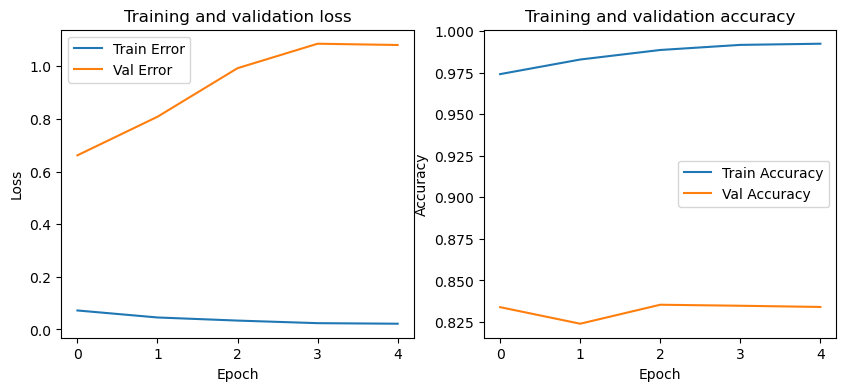

In [47]:


plot_history(history_5)

In [139]:
model_5_results = {
    'name': 'Model 5',
    'accuracy':score5[1],
    'precision':score5[2],
    'recall':score5[3],
    'f1-score': (2*(score5[2]*score5[3]))/(score5[2]+score5[3])
}


results.append(model_5_results)

<a name="5.6"> </a>
### Modelo 6 : Conv1D

We've seen before how convolutional neural networks can be used for images but they can also be used for text.

Previously we've used the layer Conv2D (which is great for images with (height, width)).

But if we want to use convolutional layers for sequences (e.g. text) we need to use Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

For more of a deep dive into what goes on behind the scenes in a CNN for text (or sequences) see the paper: https://arxiv.org/abs/1809.08037

In [140]:
def build_model_6(input_shape,name):
    inputs = layers.Input(shape=input_shape, dtype='string')
    x = encoder(inputs)
    x = embedding(x)
    x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
    x = layers.GlobalMaxPool1D()(x)
    # x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs, name=name)
    return model
    
    

model_6 = build_model_6(INPUT_SHAPE, 'model_5')

In [141]:
model_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 45)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 45, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 41, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 1)                 33  

In [142]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])

# Fit the model
history_6 = model_6.fit(train_dataset,
                        #batch_size=BATCH_SIZE,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 12s 21ms/step - loss: 0.2270 - accuracy: 0.9203 - precision: 0.9301 - recall: 0.9434 - val_loss: 0.3965 - val_accuracy: 0.8536 - val_precision: 0.8923 - val_recall: 0.8721
Epoch 2/5
515/515 [==============================] - 13s 24ms/step - loss: 0.1648 - accuracy: 0.9442 - precision: 0.9515 - recall: 0.9598 - val_loss: 0.4309 - val_accuracy: 0.8553 - val_precision: 0.8754 - val_recall: 0.8973
Epoch 3/5
515/515 [==============================] - 11s 22ms/step - loss: 0.1124 - accuracy: 0.9669 - precision: 0.9715 - recall: 0.9757 - val_loss: 0.4923 - val_accuracy: 0.8513 - val_precision: 0.8737 - val_recall: 0.8923
Epoch 4/5
515/515 [==============================] - 11s 21ms/step - loss: 0.0697 - accuracy: 0.9833 - precision: 0.9855 - recall: 0.9879 - val_loss: 0.5599 - val_accuracy: 0.8465 - val_precision: 0.8717 - val_recall: 0.8859
Epoch 5/5
515/515 [==============================] - 12s 23ms/step - loss: 0.0407 - accuracy: 0.9918

In [143]:
# evaluate
score6 = model_6.evaluate(test_dataset)

60/60 [==============================] - 0s 3ms/step - loss: 0.7445 - accuracy: 0.8025 - precision: 0.8177 - recall: 0.8411


In [144]:
model_6_results = {
    'name': 'Model 6',
    'accuracy':score6[1],
    'precision':score6[2],
    'recall':score6[3],
    'f1-score': (2*(score6[2]*score6[3]))/(score6[2]+score6[3])
}


results.append(model_6_results)

<a name="5.7"> </a>
### Model 7: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

📖 **Resource:** TensorFlow Hub is a great resource for many pretrained models but HuggingFace is also another incredible resource for many pretrained NLP models (using HuggingFace model is beyond the scope of this course but it is definitely something you should be familiar with in the NLP space): https://huggingface.co/models

In [145]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

# se encarga de text vectorization y embedding

In [146]:
def build_model_7(input_shape,name):
    # Entrada del modelo
    input_layer = layers.Input(shape=input_shape, dtype=tf.string, name="input_layer")
    squeezed_input = tf.squeeze(input_layer, axis=-1)
    # Capa de codificación de oraciones
    sentence_encoding = sentence_encoder_layer(squeezed_input)
    # Capa completamente conectada con activación ReLU
    dense_layer = layers.Dense(64, activation="relu")(sentence_encoding)
    # Capa de salida con activación sigmoide
    output_layer = layers.Dense(1, activation="sigmoid", name="output_layer")(dense_layer)
    # Crear el modelo funcional
    model = Model(inputs=input_layer, outputs=output_layer, name=name)
    return model


model_7 = build_model_7(INPUT_SHAPE,'model_7')



model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 tf.compat.v1.squeeze_3 (TFO  (None,)                  0         
 pLambda)                                                        
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
________________________________________

In [147]:
# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision','Recall'])


# Fit the model
history_7 = model_7.fit(train_dataset,
                        epochs=5,
                        validation_data=validation_dataset)

Epoch 1/5
515/515 [==============================] - 9s 13ms/step - loss: 0.5186 - accuracy: 0.7421 - precision: 0.7548 - recall: 0.8702 - val_loss: 0.4868 - val_accuracy: 0.7674 - val_precision: 0.7798 - val_recall: 0.8774
Epoch 2/5
515/515 [==============================] - 6s 12ms/step - loss: 0.4786 - accuracy: 0.7686 - precision: 0.7940 - recall: 0.8506 - val_loss: 0.4816 - val_accuracy: 0.7657 - val_precision: 0.7948 - val_recall: 0.8451
Epoch 3/5
515/515 [==============================] - 6s 11ms/step - loss: 0.4730 - accuracy: 0.7734 - precision: 0.8002 - recall: 0.8499 - val_loss: 0.4811 - val_accuracy: 0.7680 - val_precision: 0.7990 - val_recall: 0.8426
Epoch 4/5
515/515 [==============================] - 6s 11ms/step - loss: 0.4691 - accuracy: 0.7749 - precision: 0.8015 - recall: 0.8506 - val_loss: 0.4807 - val_accuracy: 0.7732 - val_precision: 0.7840 - val_recall: 0.8818
Epoch 5/5
515/515 [==============================] - 6s 12ms/step - loss: 0.4638 - accuracy: 0.7769 - pr

In [148]:
# evaluate
score7 = model_7.evaluate(test_dataset)

60/60 [==============================] - 1s 9ms/step - loss: 0.5155 - accuracy: 0.7438 - precision: 0.7635 - recall: 0.7977


In [149]:
model_7_results = {
    'name': 'Model 7',
    'accuracy':score7[1],
    'precision':score7[2],
    'recall':score7[3],
    'f1-score': (2*(score7[2]*score7[3]))/(score7[2]+score7[3])
}


results.append(model_7_results)

### Comparando los modelos y quedándonos con el mejor para afinar

In [150]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame(results)
all_model_results

,name,accuracy,precision,recall,f1-score
0,Model 1,0.829647,0.840359,0.865589,0.852787
1,Model 2,0.821222,0.825306,0.870670,0.847381
2,Model 3,0.818852,0.814925,0.882679,0.847450
3,Model 4,0.795155,0.775965,0.900693,0.847450
4,Model 5,0.811743,0.836271,0.832794,0.834529
5,Model 6,0.802528,0.817692,0.841109,0.829235
6,Model 7,0.743813,0.763484,0.797691,0.780212


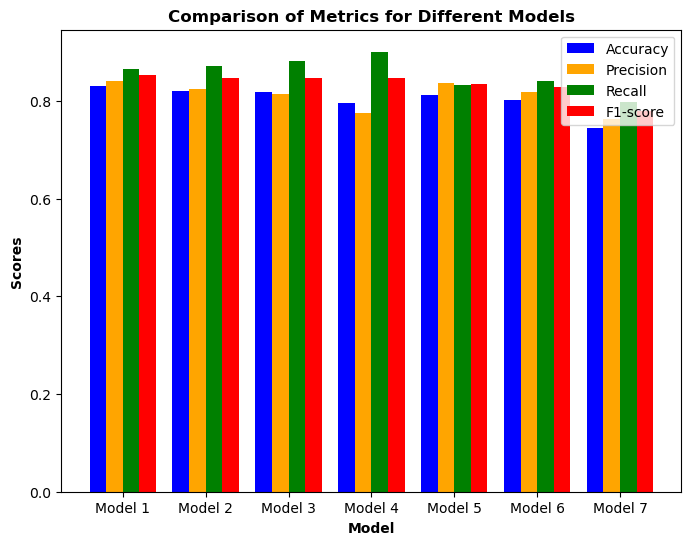

In [151]:
#all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

df = pd.DataFrame(results)



# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))


# Configurar el gráfico de barras
bar_width = 0.2
bar_positions = range(len(df['name']))
colors = ['blue', 'orange', 'green', 'red']

# Crear barras para cada métrica
plt.bar(bar_positions, df['accuracy'], width=bar_width, label='Accuracy', color=colors[0])
plt.bar([pos + bar_width for pos in bar_positions], df['precision'], width=bar_width, label='Precision', color=colors[1])
plt.bar([pos + 2*bar_width for pos in bar_positions], df['recall'], width=bar_width, label='Recall', color=colors[2])
plt.bar([pos + 3*bar_width for pos in bar_positions], df['f1-score'], width=bar_width, label='F1-score', color=colors[3])



# Añadir etiquetas y título
plt.xlabel('Model',fontweight='bold')
plt.ylabel('Scores',fontweight='bold')
plt.title('Comparison of Metrics for Different Models',fontweight='bold')
plt.xticks([pos + 1.5*bar_width for pos in bar_positions], df['name'])

# Añadir leyenda
plt.legend()

# Mostrar el gráfico de barras
plt.show()



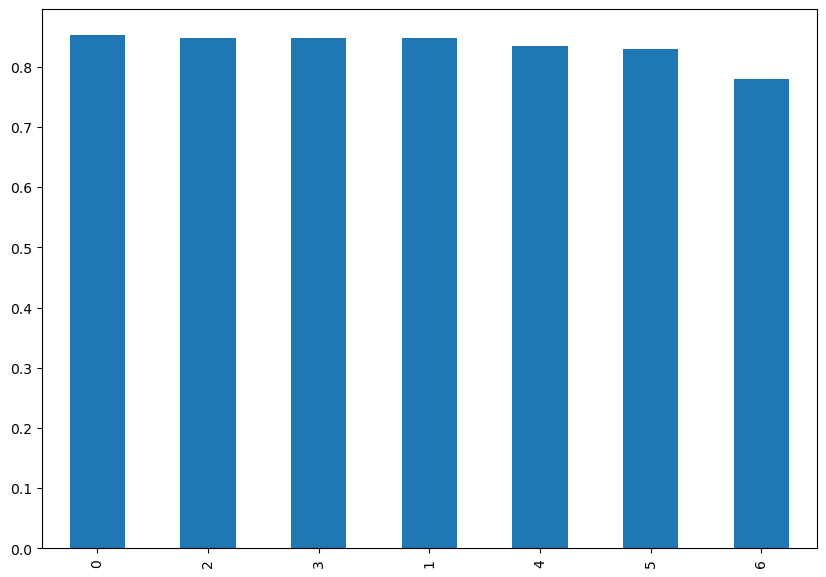

In [152]:
# Sort model results by f1-score
df.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7));

In [154]:
indice_max = all_model_results['f1-score'].idxmax()

best_model = all_model_results['name'][0]

In [155]:
f"El mejor modelo siguiendo el criterio de mayor F1-score es {best_model}"

'El mejor modelo siguiendo el criterio de mayor F1-score es Model 1'

### Ajuste de hiperparámetros

Probaremos con diferentes valores para la tasa de aprendizaje y por supuesto entrenaremos por más epochs.
También usaremos callbacks, como Early Stopping.

In [45]:
class MyHyperModel(keras_tuner.HyperModel) :
     def build(self, hp,input_shape=INPUT_SHAPE):
        inputs = layers.Input(shape=input_shape, dtype=tf.string)
        x = encoder(inputs)
        x = embedding(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        model = tf.keras.Model(inputs, outputs, name="model_1_dense")
        # compile
        model.compile(optimizer=hp.Choice('optim',['adam','adamax','sgd']),
                      loss="binary_crossentropy",
                      metrics = ['accuracy','Precision','Recall'])
        
        # A way to optimize the learning rate while also trying different optimizers
        learning_rate = hp.Choice('lr', [ 0.03, 0.01, 0.003])
        K.set_value(model.optimizer.learning_rate, learning_rate)
        # retorno
        return model




In [46]:
tuner = keras_tuner.BayesianOptimization(
                        hypermodel=MyHyperModel(),
                        objective = "val_accuracy",
                        max_trials =10, #max candidates to test
                        overwrite=True,
                        directory='search_dir',
                        project_name='sentiment_analysis')



In [48]:
tuner.search(x=train_dataset, 
             epochs=5,
             validation_data=validation_dataset)

Trial 10 Complete [00h 00m 46s]
val_accuracy: 0.8369776606559753

Best val_accuracy So Far: 0.8566569685935974
Total elapsed time: 00h 07m 05s
INFO:tensorflow:Oracle triggered exit


In [49]:
tuner.results_summary(1)

NameError: name 'tuner' is not defined

In [62]:
# mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)

final_model.summary()


Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 45)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 45, 128)           1280000   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
]

final_history = final_model.fit(
                  train_dataset, 
                  validation_data=validation_dataset,
                  epochs=100, 
                  #verbose=0,
                  batch_size=BATCH_SIZE,                  
                  callbacks=callbacks)


Epoch 1/100
515/515 [==============================] - 9s 17ms/step - loss: 0.2093 - accuracy: 0.9438 - precision: 0.9341 - recall: 0.9791 - val_loss: 0.4564 - val_accuracy: 0.8361 - val_precision: 0.8549 - val_recall: 0.8901
Epoch 2/100
515/515 [==============================] - 8s 15ms/step - loss: 0.1246 - accuracy: 0.9676 - precision: 0.9677 - recall: 0.9809 - val_loss: 0.5422 - val_accuracy: 0.8366 - val_precision: 0.8608 - val_recall: 0.8826
Epoch 3/100
515/515 [==============================] - 8s 16ms/step - loss: 0.1111 - accuracy: 0.9679 - precision: 0.9702 - recall: 0.9788 - val_loss: 0.6167 - val_accuracy: 0.8362 - val_precision: 0.8606 - val_recall: 0.8822
Epoch 4/100
515/515 [==============================] - 8s 16ms/step - loss: 0.1060 - accuracy: 0.9684 - precision: 0.9715 - recall: 0.9781 - val_loss: 0.6781 - val_accuracy: 0.8367 - val_precision: 0.8636 - val_recall: 0.8789
Epoch 5/100
515/515 [==============================] - 8s 16ms/step - loss: 0.1042 - accuracy: 0

In [64]:
final_scores = final_model.evaluate(test_dataset)


60/60 [==============================] - 0s 2ms/step - loss: 0.9376 - accuracy: 0.8112 - precision: 0.8201 - recall: 0.8568


## PREDICCIONES CON EL MODELO FINAL

In [35]:


final_model = model_1


"""
En la inferencia, la entrada debe pasar previamente por el pre-procesamiento (en este ejemplo
por preprocess_text y pre-process_text2); no hace falta que pase por las caspas de text vectorization
y embedding pues son parte del modelo
"""


# Texto de entrada para hacer una predicción
input_text = "hot new drug help covid-19"


# pre-procesamiento
input_text = preprocess_text(input_text)
input_text = preprocess_text2(input_text)


# predicción
pred = final_model.predict(np.array([input_text]))

print(f"pred: {pred}")


# Convertir la salida a una predicción binaria (0 o 1)
binary_prediction = 1 if pred[0, 0] > 0.5 else 0

# Imprimir la predicción
print("Predicción:", binary_prediction)



1/1 [==============================] - 0s 88ms/step
pred: [[0.99999994]]
Predicción: 1


In [44]:
# al usar validation_dataset no hace falta aplicar las
# funciones de pre-procesamiento pues ya las apliqué antes

y_pred = []
y_true = []


for text,label in validation_dataset:
    
    
    print(text.shape)
    
    # predictions
    predictions = final_model.predict(text,verbose=0)
    
    # paso a binario
    binary_preds = tf.squeeze(tf.round(predictions))
        
    # Añade a las listas
    y_true.extend(label.numpy())
    y_pred.extend(binary_preds.numpy())
    
    break
    


(64,)


In [37]:
# convierto a tensores

y_true = tf.constant(y_true)
y_true

<tf.Tensor: shape=(8232,), dtype=int32, numpy=array([1, 0, 1, ..., 0, 1, 0], dtype=int32)>

In [38]:
y_pred = tf.constant(y_pred)
y_pred

<tf.Tensor: shape=(8232,), dtype=float32, numpy=array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)>

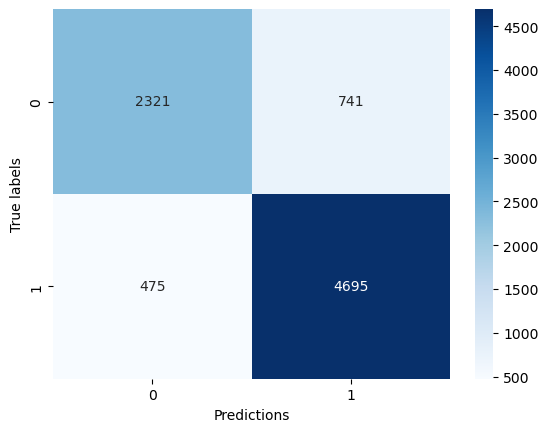

In [39]:
# Calcula la matriz de confusión
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)

# Convierte la matriz de confusión a un array NumPy para visualización
conf_matrix_np = conf_matrix.numpy()

# Visualiza la matriz de confusión (opcional, puedes omitir esta parte si no deseas visualizarla)
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predictions')
plt.ylabel('True labels')
plt.show()


Veamos las predicciones e

In [132]:



# si no quiero trabajar el dataset por lotes debo hace un unbatch

dataset = validation_dataset.unbatch()


subset = dataset.take(25)


errores = []

for text,label in subset:
    
    # text es (,) y necesito que sea (1,)
    text = tf.expand_dims(text, axis=0)
    
    # predictions
    prediction = final_model.predict(text,verbose=0)
        
    # paso a binario
    binary_pred = tf.squeeze(tf.round(prediction))
    #
    
    
    true = label.numpy()
    pred = binary_pred.numpy()
    texto = text.numpy()
    
    bytes_value = np.ndarray.tobytes(texto)
        
    if true != pred:
        texto = text.numpy()
        errores.append({'text':texto,'true label':true,'pred':pred,'pred_prob':prediction[0][0]})
        


        

    

In [134]:
errors_df = pd.DataFrame(errores)

pd.set_option('display.max_colwidth', None) # que No recorte el texto

errors_df


,text,true label,pred,pred_prob
0,[b'message start week attorney general schmitt office protect price gouging scam sure report price gouging calling 1 800 392 8222 reporting new form'],1,0.0,0.014736
1,[b'covid-19 opportunity : low oil price could mean future renewables http : //t.co/b8irzu9jqk'],1,0.0,0.116793
2,"[b' govpritzker come news reminds illinoisan panic buy toilet paper . grocery store post one pack limit ; yet , morning 4 people grabbed two six pack limited toilet paper supply ... come people coronavirus stoppani']",1,0.0,0.000703
3,[b'scientist conclude people licked ice cream put back shelf created covid-19 . trump call new finding hoax traveling across u post video licking every ice cream every grocery store . live stream go http : //w'],1,0.0,0.050372


In [122]:
# guradando el modelo



final_model.save('final_model',save_format='tf') # las capas de vect. no pueden guardasrse con h5 aún

INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets
